# Open Ocean
# Open Earth Fundation

<h1> Step 2: calculate different metrics for each modulating factor </h1>
    
This notebook is the second part of the Step1_Curate_IUCN_RedList.ipynb

<h2> Modulating Factor 3: Species Distribution Area  </h2>

From this modulating factor we can obtain information such as:
- Probability to find a certain kind of species in a specific area
- Evaluation of local, regional and globally species 
- The most visited habitats/places 
- (To be improve!)

### Data needed for this project

The data was output by `Step1_Curate_IUCN_RedList.ipynb` and are accessed through the Oceans Program s3 public bucket

- IUCN Red List dataset for ACMC:
1. s3://ocean-program/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp
2. https://ocean-program.s3.amazonaws.com/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp


- Our Marine Protected Area of interest -> ACMC polygon:

https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson

### 1. Importing libraries

In [1]:
import os
import boto3

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

In [2]:
import fiona; #help(fiona.open)

OEF functions

In [3]:
from marinebiodiversity_utils import *

### 2. Load data

**Import entire Marine Protected Area: ACMC**

ACMC is the acronyms for the entire conservation area: Cocos Marine Conservation Area

In [12]:
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

Inspect the Coordinate Reference Systems (CRS).

In [20]:
ACMC.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Get the species data**

This is the outcome from `Step1_Curate_IUCN_RedList.ipynb`.

The species information file is large (~2.1 GB), so trying to access it from the public AWS S3 bucket 'directly' can be time consuming.

Two options:
1. Have patience and run it anyway
2. Download the file in your computer and read it locally

**Option 1**

In [ ]:
%%time
df = gpd.read_file('s3://ocean-program/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp') 

In [ ]:
df.head()

**Option 2**

In [ ]:
# Initialize S3 client
s3 = boto3.client('s3')

# Set the name of the bucket and the path to the directory
bucket_name = 'ocean-program'
directory_path = 'data/processed/ACMC_IUCN_RedList/'

# List all files in the directory
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=directory_path)

# Download each file
for obj in response['Contents']:
    # Skip directories
    if obj['Key'].endswith('/'):
        continue
    
    # Download the file
    file_name = obj['Key'].split('/')[-1]
    s3.download_file(ocean-program, obj['Key'], file_name)
    print(f"Downloaded file: {file_name}")

The downloaded files will be saved in the current working directory, so to read it:

In [ ]:
%%time
df = gpd.read_file('./gdf_ACMC_IUCN_range_status_filtered.shp') 

In [23]:
df.head()

,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,redlistCat,scientific,geometry
0,13,1504292,177964,Ctenochaetus marginatus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Ctenochaetus marginatus,"MULTIPOLYGON (((173.90343 3.44131, 173.90535 3..."
1,62,1604964,180245,Holothuria kefersteinii,1,1,1,IUCN,2012,International Union for Conservation of Nature,Extant (resident),None,None,None,None,None,Data Deficient,Holothuria kefersteinii,"MULTIPOLYGON (((-117.10683 32.44577, -117.1034..."
2,69,1614313,180318,Holothuria imitans,1,1,1,IUCN,2012,International Union for Conservation of Nature,Extant (resident),None,None,None,None,None,Least Concern,Holothuria imitans,"MULTIPOLYGON (((132.11722 -2.12133, 132.11264 ..."
3,76,1621878,180373,Isostichopus fuscus,1,1,1,IUCN,2012,International Union for Conservation of Nature,Extant (resident),None,None,None,None,None,Endangered,Isostichopus fuscus,"MULTIPOLYGON (((-114.81055 31.82298, -114.7885..."
4,95,1735660,183294,Strongylura exilis,1,1,1,IUCN,2018,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,Least Concern,Strongylura exilis,"MULTIPOLYGON (((-91.24865 -0.67985, -91.24889 ..."


<h1> 2.2. Preliminary calculations </h1> 

In [24]:
area_of_conservation = ACMC.geometry.item()

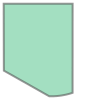

In [25]:
area_of_conservation

## 2.2.1 Distribution Ratio #1

Let's to define a generic distribution ratio based on the total conservation area (ACMC's area) and the total distribution area for each species:

DistRatio 1 = $\frac{\text{total conservation area}}{\text{distribution area}}$

**Analysis - Scenarios**

1. `DistRatio 1 > 1` 

`Total conservation area > Distribution area`

This could mean that: 
- These species have a smallest distribution area than ACMC's area
- These can be endemic of ACMC or endemic of another site in the Eastern Tropical Pacific because here we're just considering numbers without geospatial reference
- These species have lack spatial information

2. `DistRatio 1 = 1`

This could mean that:

- These species have the same range size as ACMC

3. `DistRatio 1 < 1`

`Total conservation area < Distribution area`

This could mean that:

- These species have a high spatial coverage
- They could be migratory species or global species

So, let's to calculate the Distibution Ratio 1

In [27]:
df['area'] = df.area
df["DistRatio"] = area_of_conservation.area/df.area
df["DistFactorPerc"] = 100*df.DistRatio
df.head().DistRatio

0    0.075302
1    0.121674
2    0.030069
3    0.133672
4    0.112767
Name: DistRatio, dtype: float64

<AxesSubplot:>

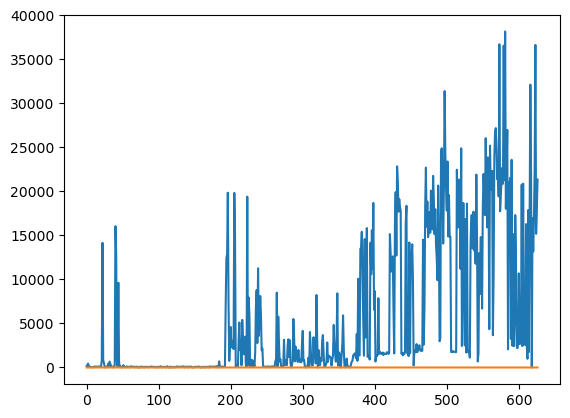

In [29]:
# This plots the size of the range of each species
df.geometry.area.plot()
# This plots the size of the value of the DistRatio of each species
df.DistRatio.plot()

Let's look more closely at the DistRatio graph:

Text(0.5, 1.0, 'Plot 2: Distribution Ratio 1')

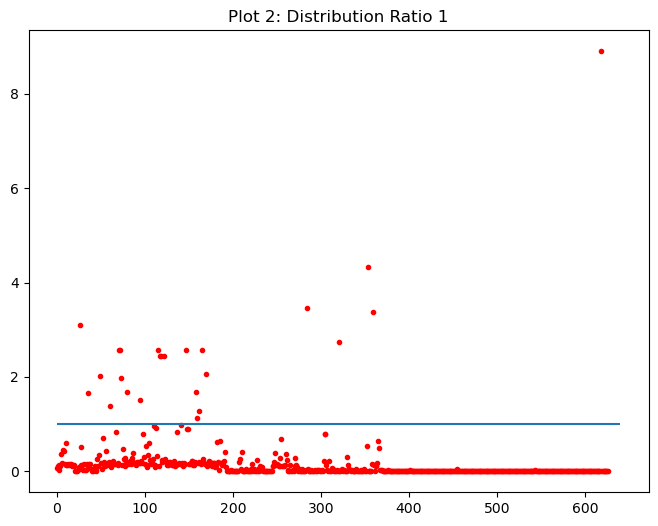

In [38]:
plt.figure(figsize=(8,6))
plt.plot(df.DistRatio,'.r')
plt.hlines(y=1,xmin=0, xmax=640)
plt.title('Plot 2: Distribution Ratio 1')

Text(0.5, 1.0, 'Plot 3: Histogram of Distribution Ratio 1')

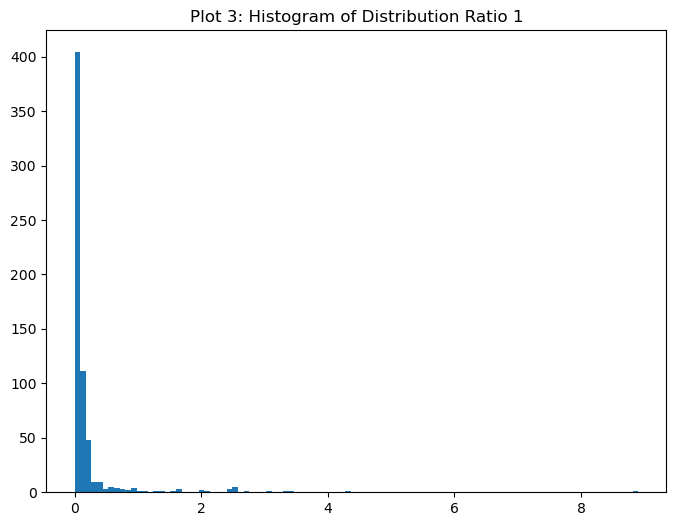

In [47]:
plt.figure(figsize=(8,6))
plt.hist(df.DistRatio,bins=100)
plt.title('Plot 3: Histogram of Distribution Ratio 1')

In [51]:
print('The species with the highest DistRatio is: '+str(df.BINOMIAL[np.where(df.DistRatio == df.DistRatio.max())[0]]))

The species with the highest DistRatio is: 618    Pristis pristis
Name: BINOMIAL, dtype: object


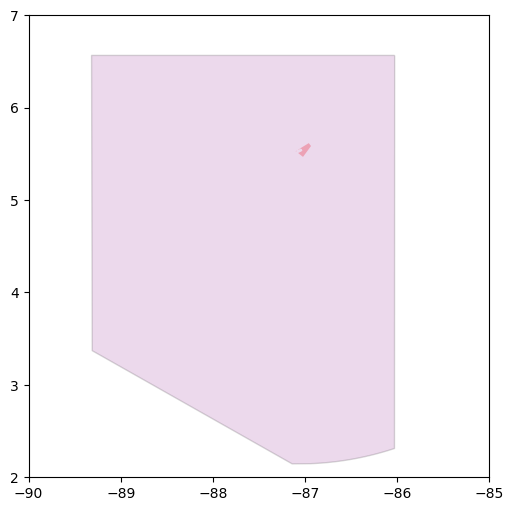

In [61]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(8,6))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

df[df.DistRatio==np.max(df.DistRatio)].plot(ax = ax, color = 'r', alpha = 0.25)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ACMC.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

ax.set_xlim((-90, -85))
ax.set_ylim((2, 7))
plt.show();

In [62]:
print('The species with the smallest DistRatio is: '+str(df.BINOMIAL[np.where(df.DistRatio == df.DistRatio.min())[0]]))

The species with the smallest DistRatio is: 581    Orcinus orca
Name: BINOMIAL, dtype: object


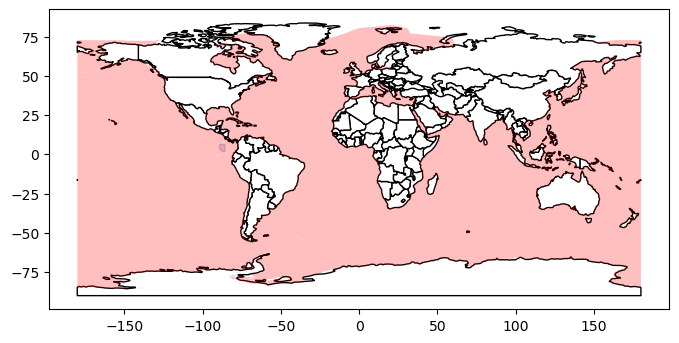

In [65]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(8,6))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

df[df.DistRatio==np.min(df.DistRatio)].plot(ax = ax, color = 'r', alpha = 0.25)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ACMC.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

#ax.set_xlim((-90, -85))
#ax.set_ylim((2, 7))
plt.show();

Next step:
- Figure out how we can convert this information in a base unit
- Per species? per range of DistRatio?

To be completed!